In [ ]:
from glob import glob

ass_paths = glob("../data/Subtitles/*.ass")
srt_paths = glob("../data/Subtitles/*.srt")

subtitles_paths = sorted(ass_paths + srt_paths)



In [ ]:
subtitles_paths[:5]

In [ ]:
import re

scripts = []
episode_num = []

for path in subtitles_paths:
    with open(path, "r", encoding="utf-8", errors="ignore") as file:
        lines = file.readlines()

        # Skip header lines if it's an .ass file
        if path.endswith(".ass"):
            lines = lines[27:]
            rows = [",".join(line.split(",")[9:]) for line in lines]
            rows = [line.replace("\\N", " ") for line in rows]
            script = " ".join(rows)

        elif path.endswith(".srt"):
            # Basic .srt parsing: skip subtitle numbers and timestamps
            lines = [line.strip() for line in lines if line.strip()]
            rows = [
                line
                for line in lines
                if not re.match(r"^\d+$", line)
                and not re.match(r"^\d{2}:\d{2}:\d{2},\d{3}", line)
            ]
            script = " ".join(rows)

        # Try to extract episode number using regex
        filename = path.split("/")[-1]
        match = re.search(r"\d+", filename)
        if match:
            episode = int(match.group())
            scripts.append(script)
            episode_num.append(episode)
        else:
            print(f"⚠️ Couldn't find episode number in filename: {filename}")

In [ ]:
%pip install pandas

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict({"episode": episode_num, "script": scripts})

In [ ]:
df.head()

In [ ]:
%pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm


In [ ]:
import spacy

nlp = spacy.load("en_core_web_trf")

In [ ]:
doc = nlp("Mark went to Germany")

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
%pip install nltk

In [28]:
doc = nlp(script)
script_sentences = [sent.text for sent in doc.sents]

def get_ners(script):
    doc = nlp(script)
    ner_output = []

    for sent in doc.sents:
        ners = set()
        for ent in sent.ents:
            if ent.label_ == "PERSON":
                full_name = ent.text
                first_name = full_name.split(" ")[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output




In [29]:
df["ners"] = df["script"].apply(get_ners)


In [31]:
window = 10
entity_relationship = []

for row in df["ners"]:
    previous_entities_in_window = []

    for sentence in row:
        previous_entities_in_window.append(sentence)
        previous_entities_in_window = previous_entities_in_window[-10:]

        previous_entities_flattened = sum(previous_entities_in_window, [])

        for entity in sentence:
            for entity_in_window in previous_entities_flattened:
                if entity != entity_in_window:
                    entity_rel = sorted([entity, entity_in_window])
                    entity_relationship.append(entity_rel)

In [32]:
relationship_df = pd.DataFrame({"value": entity_relationship})

In [33]:
relationship_df["source"] = relationship_df["value"].apply(lambda x: x[0])
relationship_df["target"] = relationship_df["value"].apply(lambda x: x[1])

In [34]:
relationship_df = relationship_df.groupby(["source", "target"]).count().reset_index()

In [35]:
relationship_df = relationship_df.sort_values("value", ascending=False)
relationship_df.head()

,source,target,value
4973,Naruto,Sora,367
4944,Naruto,Sasuke,319
4935,Naruto,Sakura,264
5601,Sakura,Sasuke,151
3355,Ino,Sakura,116


In [36]:
relationship_df = relationship_df.head(200)

In [39]:
import networkx as nx

G = nx.from_pandas_edgelist(
    relationship_df,
    source="source",
    target="target",
    edge_attr="value",
    create_using=nx.Graph(),
)

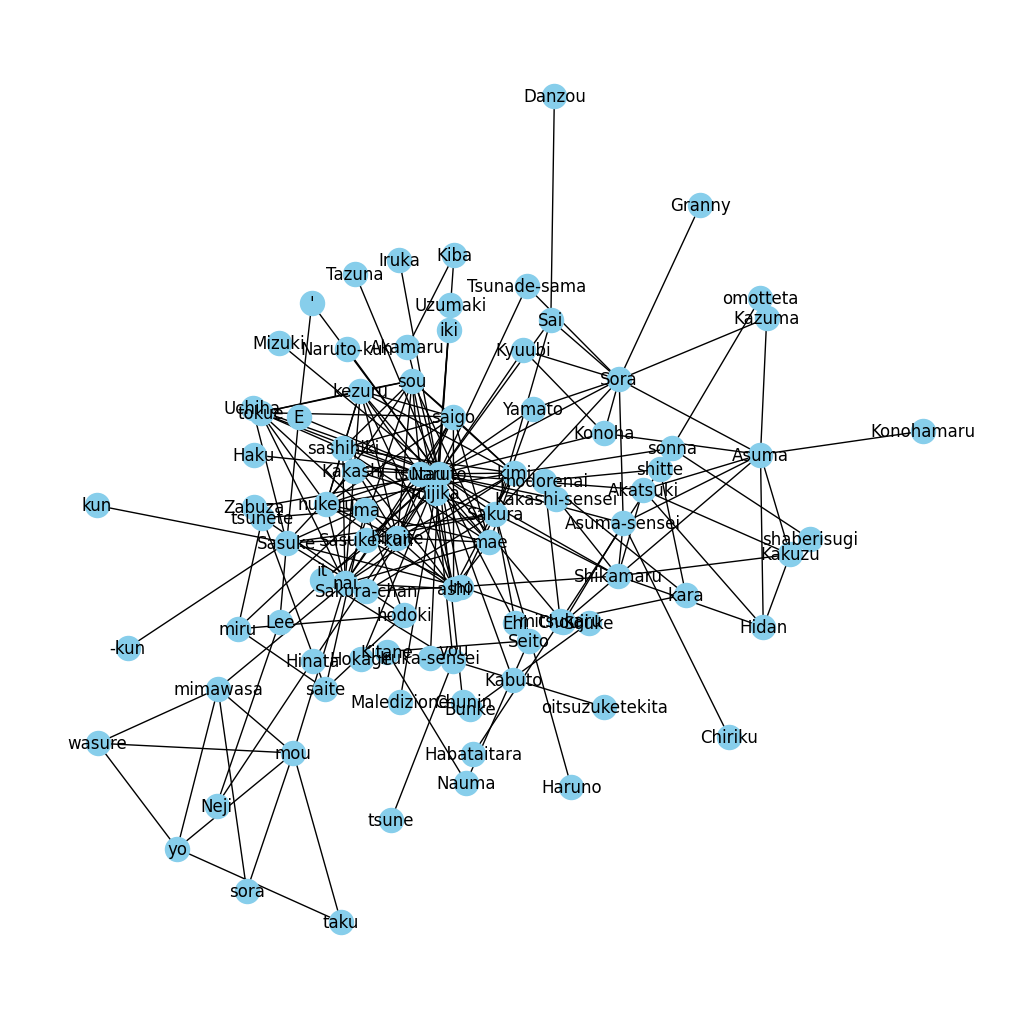

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [47]:
from pyvis.network import Network

net = Network(
    notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color="white"
)

node_degree = dict(G.degree)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, "size")

net.from_nx(G)
net.show("naruto.html", notebook=True)

naruto.html


In [46]:
from IPython.display import IFrame
IFrame("naruto.html", width=1000, height=700)